In [2]:
## 📌 1. Import Required Libraries
#Basic
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import cv2

# TensorFlow & Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries imported successfully ✅")

Libraries imported successfully ✅


## Step 2: Define Dataset Paths

We define the base directory path where our dataset is stored. 
Inside the `data` folder, we have separate directories for training, validation, and testing data.


In [4]:
## 📌 2. Define Dataset Paths

base_dir = '../data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Testing directory: {test_dir}")


Training directory: ../data\train
Validation directory: ../data\val
Testing directory: ../data\test


## Step 3: Check Class Distribution

We count the number of images present in each class (`PNEUMONIA` and `NORMAL`) across the train, validation, and test datasets.
This helps us understand if the dataset is balanced or imbalanced.


In [3]:
# Step 3 - Check Class Distribution

for dataset, path in [('Train', train_dir), ('Validation', val_dir), ('Test', test_dir)]:
    for label in ['PNEUMONIA', 'NORMAL']:
        count = len(os.listdir(os.path.join(path, label)))
        print(f"{dataset} - {label}: {count} images")


Train - PNEUMONIA: 3876 images
Train - NORMAL: 1342 images
Validation - PNEUMONIA: 9 images
Validation - NORMAL: 9 images
Test - PNEUMONIA: 390 images
Test - NORMAL: 234 images


## Step 4: Visualize Sample Images

Before feeding images into our model, we will visualize a few examples from both classes (`PNEUMONIA` and `NORMAL`) to understand how they look.


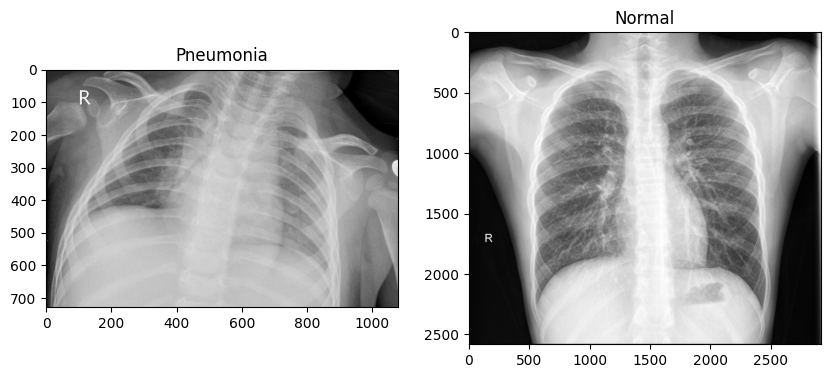

In [4]:
# Step 4 - Visualize Sample Images

import random

# Get random image paths
pneumonia_img = os.listdir(os.path.join(train_dir, 'PNEUMONIA'))
normal_img = os.listdir(os.path.join(train_dir, 'NORMAL'))

sample_pneumonia = os.path.join(train_dir, 'PNEUMONIA', random.choice(pneumonia_img))
sample_normal = os.path.join(train_dir, 'NORMAL', random.choice(normal_img))

# Plot images
plt.figure(figsize=(10,5))

# Pneumonia sample
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(sample_pneumonia), cmap='gray')
plt.title("Pneumonia")

# Normal sample
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(sample_normal), cmap='gray')
plt.title("Normal")

plt.show()


## Step 5: Data Preprocessing and Augmentation

Since our images have varying sizes, we will resize them to a fixed shape.  
We will also apply image augmentation techniques such as:
- Rotation
- Zoom
- Horizontal flipping
- Shifting

This will help our model learn better and reduce overfitting.


In [5]:
# Step 5 - Preprocessing and Augmentation

# Use 224x224 for future flexibility (transfer learning ready)
IMG_SIZE = 224

# ImageDataGenerator for training set with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale validation and test sets (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Step 6: Build the CNN Model

We will build a Convolutional Neural Network (CNN) architecture for binary classification (Pneumonia vs Normal).

- Input shape: 224x224x3 (RGB images)
- Use Convolutional, MaxPooling, Flatten, Dense, Dropout layers.
- Compile with `binary_crossentropy` loss (since it's 2-class problem).


In [6]:
# Step 6 - Build CNN Model

model = Sequential()

# 1st Conv Layer
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Conv Layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Conv Layer
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


c:\Users\Poojitha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## Step 7: Train the CNN Model (with Best Weights Restoration)

We will train the model using EarlyStopping with `restore_best_weights=True`.

- This ensures that after training, the model automatically uses the weights from the epoch where validation loss was best.
- Helps to prevent overfitting and keeps best performing model for evaluation.


In [ ]:
# Step 7 - Train the CNN Model
import tensorflow as tf
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stop]
)


c:\Users\Poojitha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1125s 7s/step - accuracy: 0.7109 - loss: 0.6696 - val_accuracy: 0.7500 - val_loss: 0.5249
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.8378 - loss: 0.3466 - val_accuracy: 0.8750 - val_loss: 0.4861
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4717s 29s/step - accuracy: 0.8688 - loss: 0.3136 - val_accuracy: 0.7500 - val_loss: 0.6336
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 472s 3s/step - accuracy: 0.8873 - loss: 0.2694 - val_accuracy: 0.6875 - val_loss: 1.0543
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - accuracy: 0.8988 - loss: 0.2451 - val_accuracy: 0.8125 - val_loss: 0.6231


## Step 8: Model Evaluation and Visualization

- We will plot the training and validation accuracy & loss.
- This helps us understand how well the model learned and where overfitting may have started.


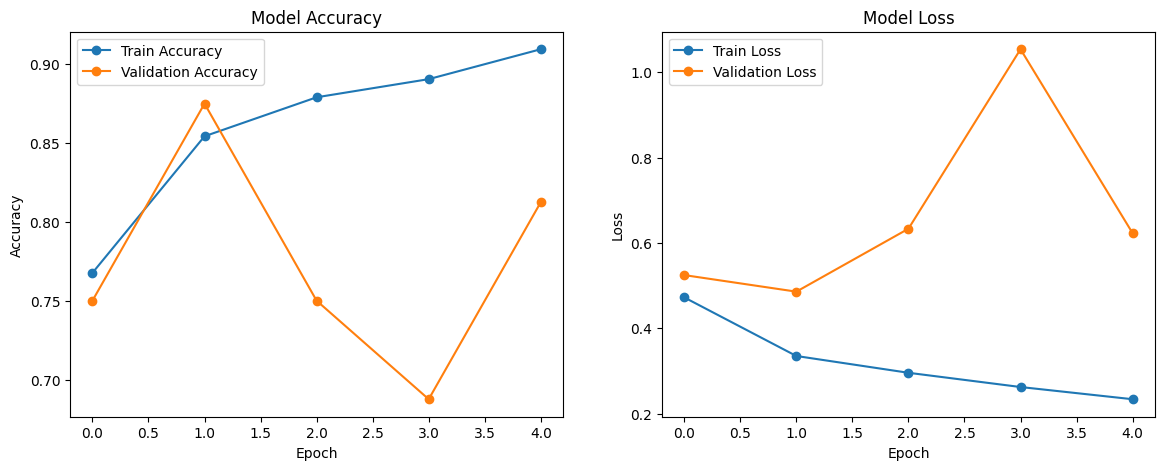

In [8]:
# Step 8 - Visualize Accuracy and Loss

import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Step 9: Model Evaluation on Test Data

- Now we will evaluate the model on completely unseen test data.
- This gives us an unbiased estimate of model performance.
- We will also generate a classification report and confusion matrix.


20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.7939 - loss: 0.4590
Test Accuracy: 84.46%
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 766ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.80      0.78      0.79       234
   PNEUMONIA       0.87      0.88      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.83      0.83       624
weighted avg       0.84      0.84      0.84       624



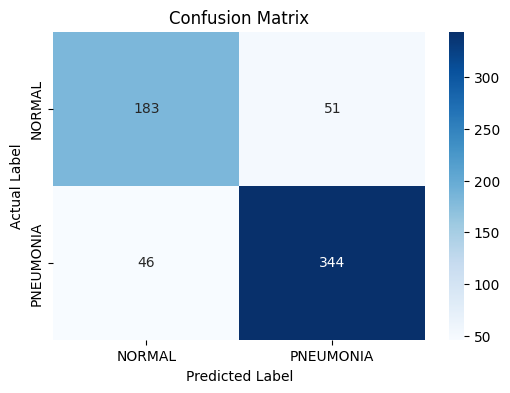

In [9]:
# Step 9 - Evaluate on Test Data

# Reset test generator
test_generator.reset()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Predict classes
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = (predictions > 0.5).astype("int32")

# True classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


## Step 10: Save the Trained Model

- We will now save the trained model for future use.
- Saved model can be used for deployment or re-loading without re-training.


In [ ]:
model_save_path = "../models/baseline"

# Save model in TensorFlow SavedModel format
model.save(os.path.join(model_save_path, "pneumonia_cnn_model.h5"))


print("Model saved successfully ✅")


Model saved successfully ✅
